In [16]:
import random

import numpy as np
import pandas as pd

from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [17]:
chunks = pd.read_json('data_json/train.jsonl', lines=True, chunksize=100_000)

In [18]:
train = pd.DataFrame()

In [19]:
%%time

for i, chunk in enumerate(chunks):
    event_dict = {
        'session': [],
        'aid':     [],
        'ts':      [],
        'type':    []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                               chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    train = pd.concat([train, chunk_session])

CPU times: user 18.7 s, sys: 7.11 s, total: 25.8 s
Wall time: 27.5 s


In [20]:
train = train.reset_index(drop=True)
display(train)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [21]:
train.rename(index=str, columns={'session': 'customer_id',
                                 'aid' : 'product_code',
                                 'ts' : 'time_stamp',
                                 'type' : 'event_type'}, inplace=True)
display(train)

,customer_id,product_code,time_stamp,event_type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [23]:
train['time_stamp'] = pd.to_datetime(train['time_stamp'], unit='ms')
display(train)

,customer_id,product_code,time_stamp,event_type
0,0,1517085,2022-07-31 22:00:00.025,clicks
1,0,1563459,2022-07-31 22:01:44.511,clicks
2,0,1309446,2022-08-01 15:23:59.426,clicks
3,0,16246,2022-08-01 15:28:39.997,clicks
4,0,1781822,2022-08-01 15:31:11.344,clicks
...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967,clicks
10285557,199999,849970,2022-08-01 06:47:29.078,clicks
10285558,199999,1052480,2022-08-01 06:49:07.035,clicks
10285559,199999,487255,2022-08-01 06:49:21.116,clicks


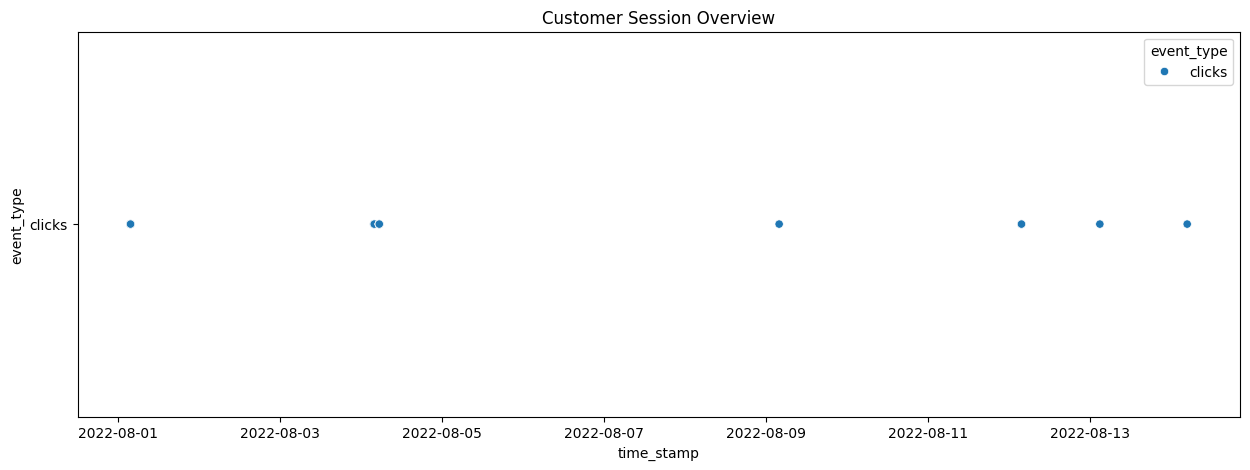

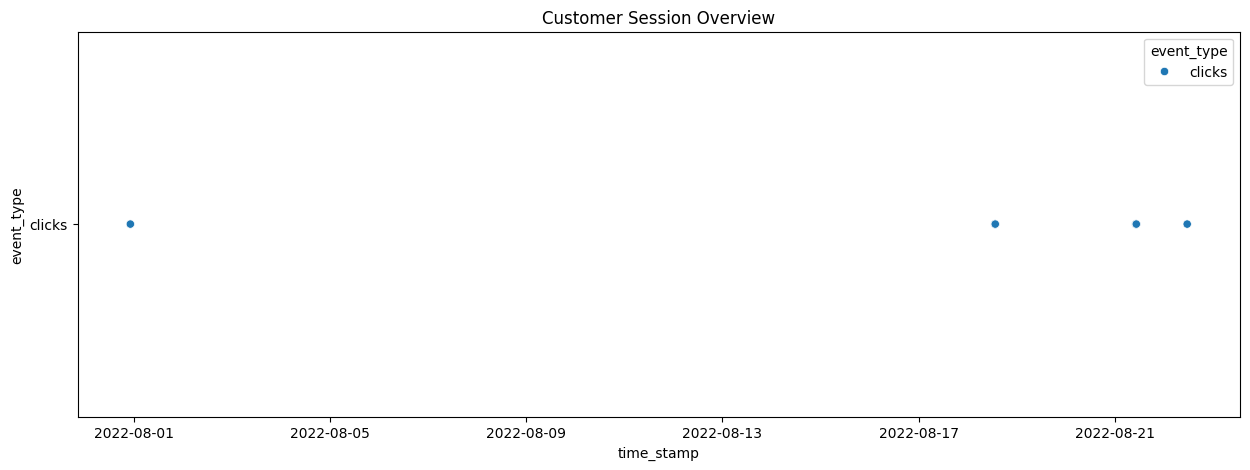

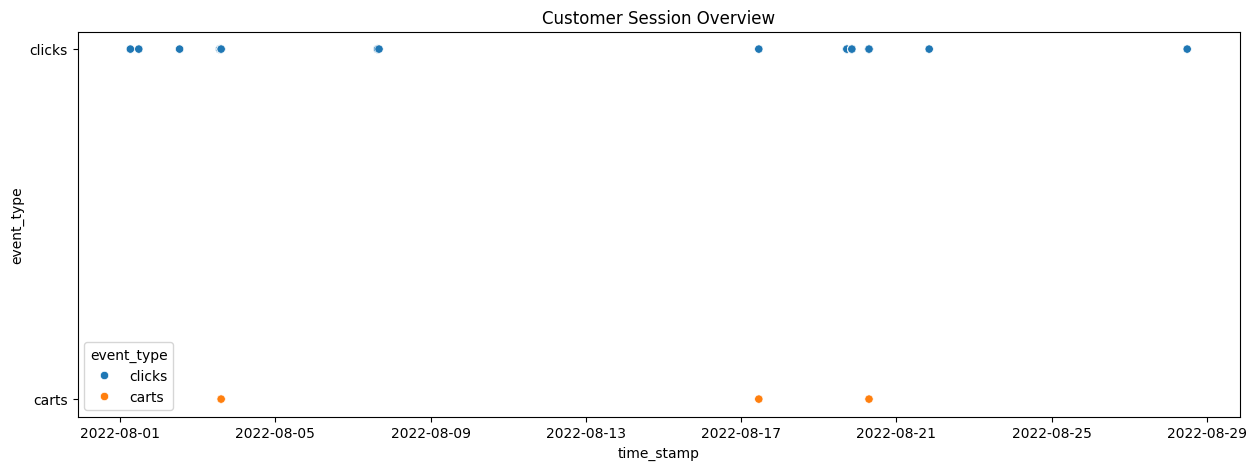

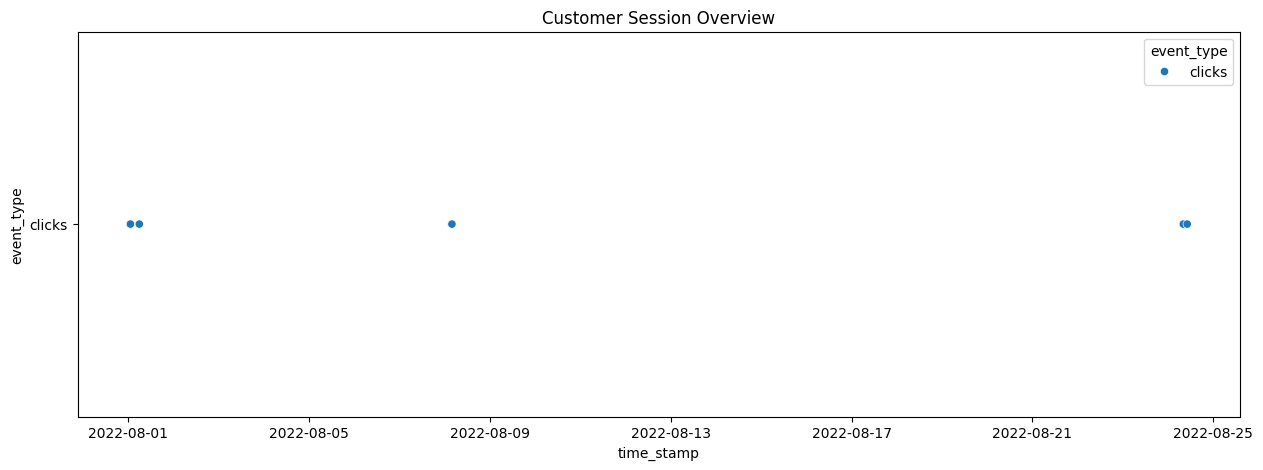

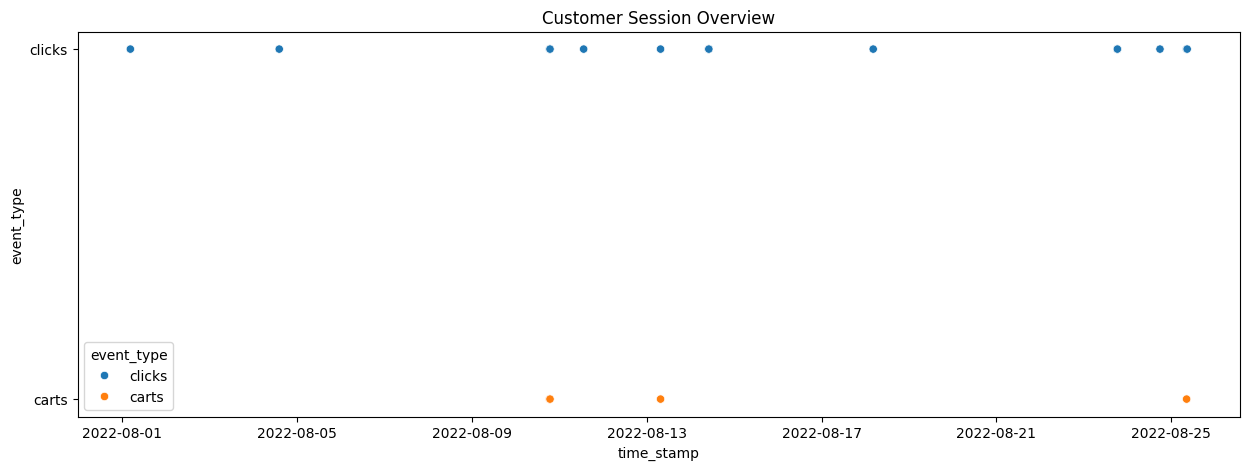

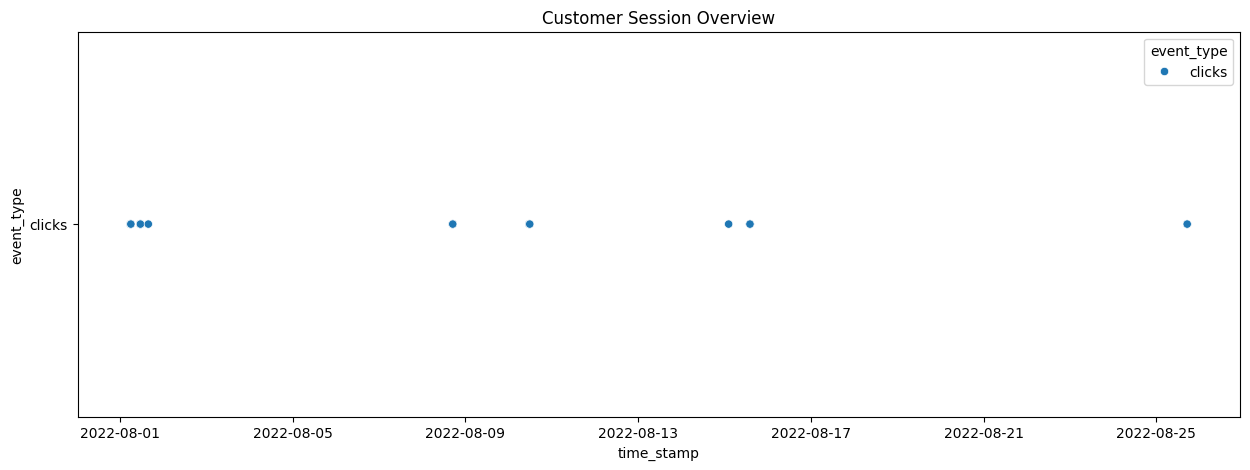

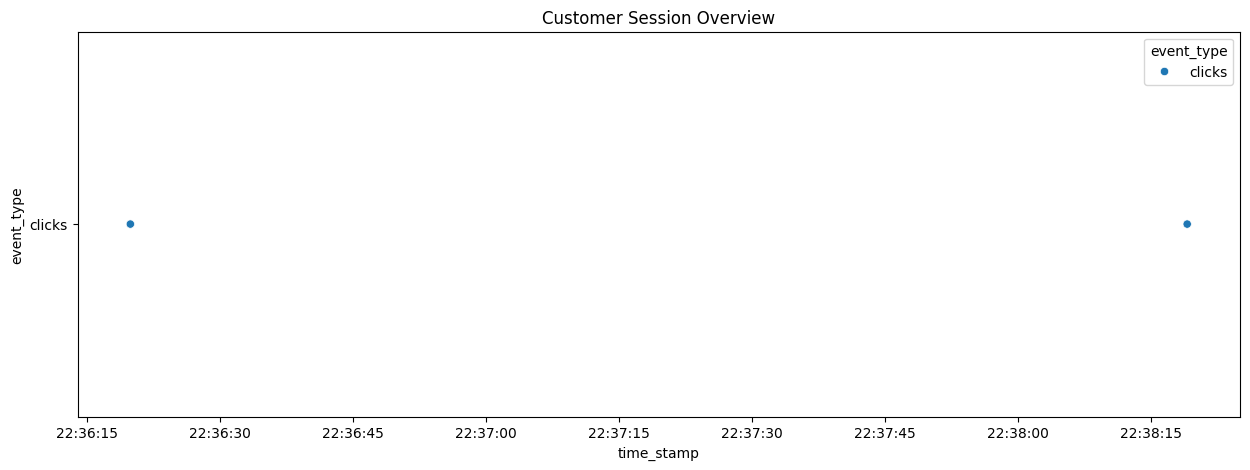

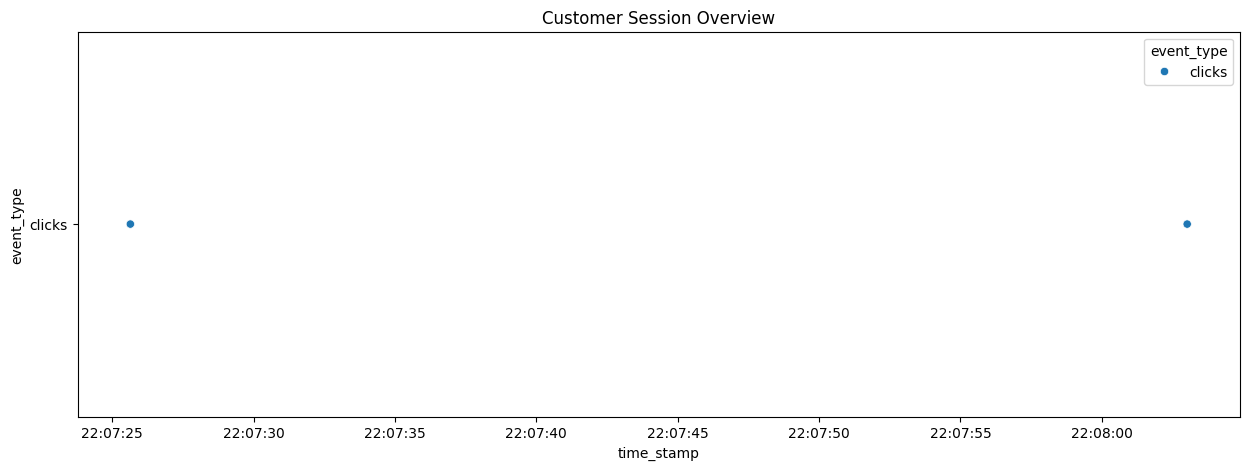

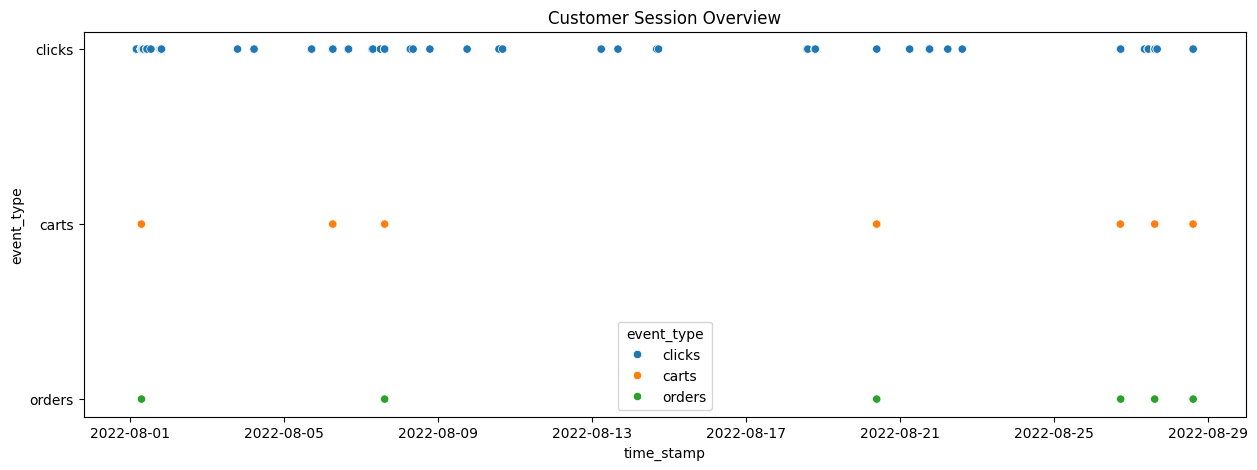

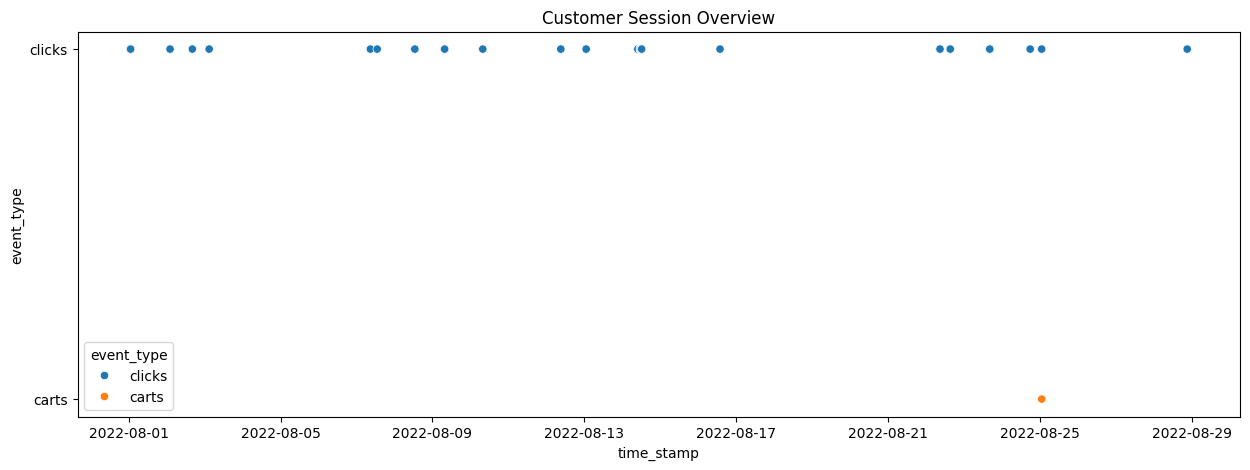

In [24]:
for customer in random.sample(range(200000), 10):
    customer_df = train[train['customer_id'] == customer]
    customer_df = customer_df.sort_values(by='time_stamp')
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title('Customer Session Overview')
    sns.scatterplot(x='time_stamp', y='event_type', data=customer_df, hue='event_type', ax=ax)
    plt.show()    

#### Order after add to cart

In [25]:
# Percentage of orders occuring after add to cart events
train['order'] = train['event_type'].apply(lambda x: 1 if x == 'orders' else 0)
train['add_to_cart'] = train['event_type'].apply(lambda x: 1 if x == 'carts' else 0)
train['order_after_cart'] = train['order'].shift(-1) + train['add_to_cart']
train['order_after_cart'] = train['order_after_cart'].apply(lambda x: 1 if x == 2 else 0)

In [26]:

perc = train['order_after_cart'].value_counts(normalize=True)[1]

print(f'Percentage of orders occuring after add to cart events: {perc:.2%}')

Percentage of orders occuring after add to cart events: 0.63%


#### Add to cart after click

In [28]:
# Percentage of add_to_cart events occuring after click events
train['click'] = train['event_type'].apply(lambda x: 1 if x == 'clicks' else 0)
train['cart_after_click'] = train['click'].shift(-1) + train['add_to_cart']
train['cart_after_click'] = train['cart_after_click'].apply(lambda x: 1 if x == 2 else 0)

perc = train['cart_after_click'].value_counts(normalize=True)[1]

print(f'Percentage of add_to_cart events occuring after click events: {perc:.2%}')

Percentage of add_to_cart events occuring after click events: 5.89%


#### Click after click

In [29]:

# Percentage of click events occuring after click events
train['click_after_click'] = train['click'].shift(-1) + train['click']
train['click_after_click'] = train['click_after_click'].apply(lambda x: 1 if x == 2 else 0)

perc = train['click_after_click'].value_counts(normalize=True)[1]

print(f'Percentage of click events occuring after click events: {perc:.2%}')

Percentage of click events occuring after click events: 83.64%


In [30]:
display(train)

,customer_id,product_code,time_stamp,event_type,order,add_to_cart,order_after_cart,click,cart_after_click,click_after_click
0,0,1517085,2022-07-31 22:00:00.025,clicks,0,0,0,1,0,1
1,0,1563459,2022-07-31 22:01:44.511,clicks,0,0,0,1,0,1
2,0,1309446,2022-08-01 15:23:59.426,clicks,0,0,0,1,0,1
3,0,16246,2022-08-01 15:28:39.997,clicks,0,0,0,1,0,1
4,0,1781822,2022-08-01 15:31:11.344,clicks,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967,clicks,0,0,0,1,0,1
10285557,199999,849970,2022-08-01 06:47:29.078,clicks,0,0,0,1,0,1
10285558,199999,1052480,2022-08-01 06:49:07.035,clicks,0,0,0,1,0,1
10285559,199999,487255,2022-08-01 06:49:21.116,clicks,0,0,0,1,0,1


In [31]:
grouped_train = train.groupby('customer_id').count()
display(grouped_train)

,product_code,time_stamp,event_type,order,add_to_cart,order_after_cart,click,cart_after_click,click_after_click
customer_id,,,,,,,,,
0,276,276,276,276,276,276,276,276,276
1,32,32,32,32,32,32,32,32,32
2,33,33,33,33,33,33,33,33,33
3,226,226,226,226,226,226,226,226,226
4,19,19,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...
199995,17,17,17,17,17,17,17,17,17
199996,25,25,25,25,25,25,25,25,25
199997,154,154,154,154,154,154,154,154,154


In [33]:
grouped_train = grouped_train[['product_code', 'time_stamp', 'event_type']]
display(grouped_train)

,product_code,time_stamp,event_type
customer_id,,,
0,276,276,276
1,32,32,32
2,33,33,33
3,226,226,226
4,19,19,19
...,...,...,...
199995,17,17,17
199996,25,25,25
199997,154,154,154


In [34]:
grouped_train.describe()

,product_code,time_stamp,event_type
count,200000.000000,200000.000000,200000.000000
mean,51.427805,51.427805,51.427805
std,75.456583,75.456583,75.456583
min,2.000000,2.000000,2.000000
25%,6.000000,6.000000,6.000000
50%,19.000000,19.000000,19.000000
75%,62.000000,62.000000,62.000000
max,495.000000,495.000000,495.000000


#### Distribution of number of products viewed by customers

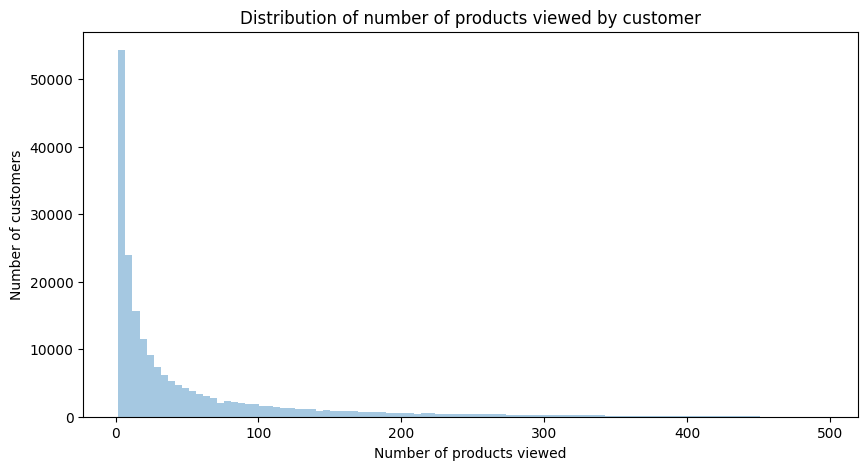

In [35]:

plt.figure(figsize=(10, 5))
sns.distplot(grouped_train['product_code'], kde=False, bins=100)
plt.title('Distribution of number of products viewed by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of customers')
plt.show()

#### Event distribution across entire userbase¶

Majority of the events in the sampled data are clicks, followed by addition to carts and orders. It is evident that a very small chunk of customers sessions translate to a conversion. At this point it will be interesting to understand the relationship b/w length of the session and the conversion rate.

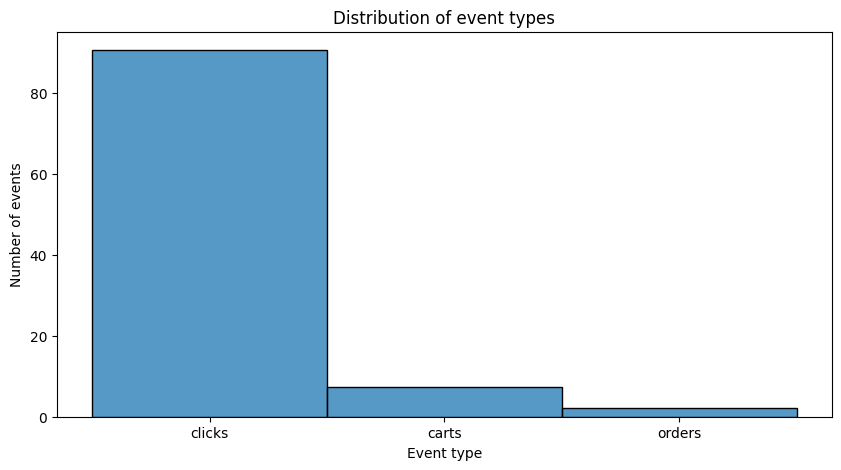

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(train['event_type'], stat='percent', kde=False, bins=100)
plt.title('Distribution of event types')
plt.xlabel('Event type')
plt.ylabel('Number of events')
plt.show()

In [41]:
grouped_train_orders = train[train['event_type'] == 'orders'].groupby('customer_id').count().join(grouped_train, lsuffix='_orders', rsuffix='_views')   
grouped_train_orders = grouped_train_orders.drop(['product_code_views', 'time_stamp_views'], axis=1).rename(columns={'event_type_views': 'event_count'})
grouped_train_orders = grouped_train_orders[['product_code_orders', 'time_stamp_orders', 'event_type_orders', 'event_count']]
display(grouped_train_orders)

,product_code_orders,time_stamp_orders,event_type_orders,event_count
customer_id,,,,
0,4,4,4,276
3,5,5,5,226
4,1,1,1,19
11,2,2,2,93
12,1,1,1,5
...,...,...,...,...
199980,1,1,1,32
199985,4,4,4,37
199991,2,2,2,27


#### Number of products viewed vs. number of products ordered¶

There seems to be a slight correlation b/w number of products viewed vs number of products ordered by a customer.

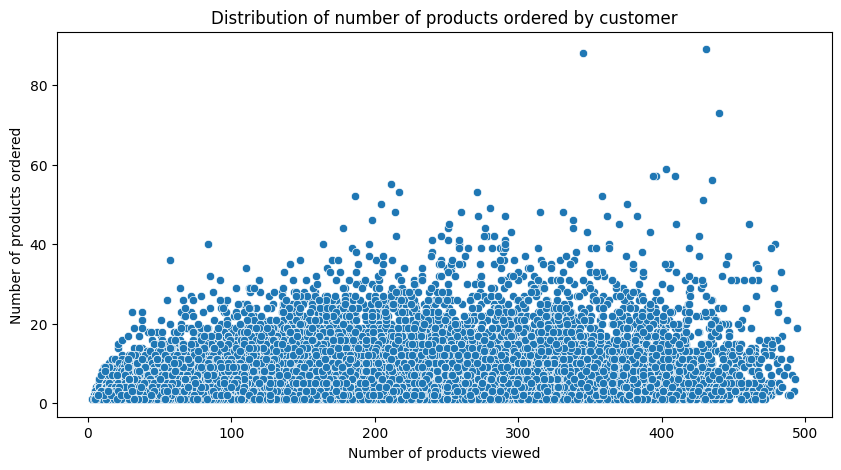

In [42]:
# plot trend between event count and event type orders
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_train_orders['event_count'], y=grouped_train_orders['product_code_orders'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of products ordered')
plt.show()

In [43]:
display( grouped_train_orders[grouped_train_orders['product_code_orders'] < 100])

,product_code_orders,time_stamp_orders,event_type_orders,event_count
customer_id,,,,
0,4,4,4,276
3,5,5,5,226
4,1,1,1,19
11,2,2,2,93
12,1,1,1,5
...,...,...,...,...
199980,1,1,1,32
199985,4,4,4,37
199991,2,2,2,27


#### Distribution of number of products ordered by customers

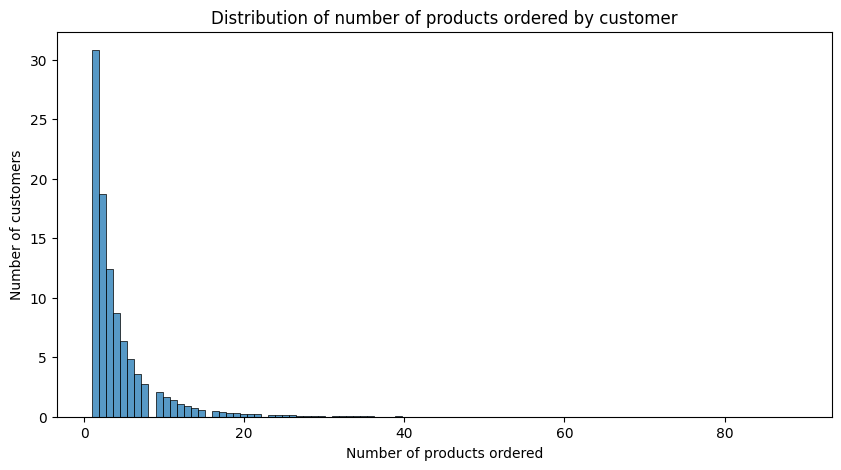

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_orders['product_code_orders'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of customers')
plt.show()

In [46]:
grouped_train_clicks = train[train['event_type'] == 'clicks'].groupby('customer_id').count().join(grouped_train, lsuffix='_clicks', rsuffix='_views')   
grouped_train_clicks = grouped_train_clicks.drop(['product_code_views', 'time_stamp_views'], axis=1).rename(columns={'event_type_views': 'event_count'})
grouped_train_clicks = grouped_train_clicks[['product_code_clicks', 'time_stamp_clicks', 'event_type_clicks', 'event_count']]
display(grouped_train_clicks)

,product_code_clicks,time_stamp_clicks,event_type_clicks,event_count
customer_id,,,,
0,255,255,255,276
1,24,24,24,32
2,32,32,32,33
3,200,200,200,226
4,15,15,15,19
...,...,...,...,...
199995,17,17,17,17
199996,24,24,24,25
199997,119,119,119,154


#### Distribution of number of products clicked

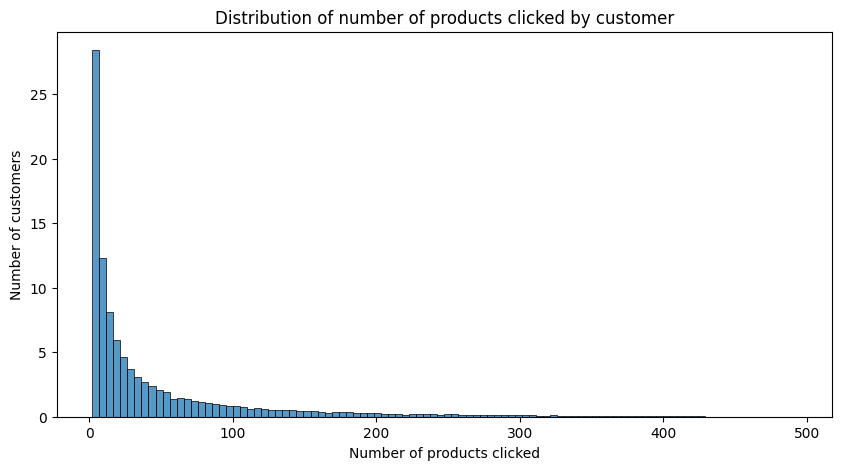

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_clicks['product_code_clicks'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products clicked by customer')
plt.xlabel('Number of products clicked')
plt.ylabel('Number of customers')
plt.show()

In [49]:
grouped_train_carts = train[train['event_type'] == 'carts'].groupby('customer_id').count().join(grouped_train, lsuffix='_carts', rsuffix='_views')
grouped_train_carts = grouped_train_carts.drop(['product_code_views', 'time_stamp_views'], axis=1).rename(columns={'event_type_views': 'event_count'})
grouped_train_carts = grouped_train_carts[['product_code_carts', 'time_stamp_carts', 'event_type_carts', 'event_count']]
display(grouped_train_carts)

,product_code_carts,time_stamp_carts,event_type_carts,event_count
customer_id,,,,
0,17,17,17,276
1,8,8,8,32
2,1,1,1,33
3,21,21,21,226
4,3,3,3,19
...,...,...,...,...
199991,4,4,4,27
199992,14,14,14,153
199993,5,5,5,31


#### Distribution of number of products added to cart

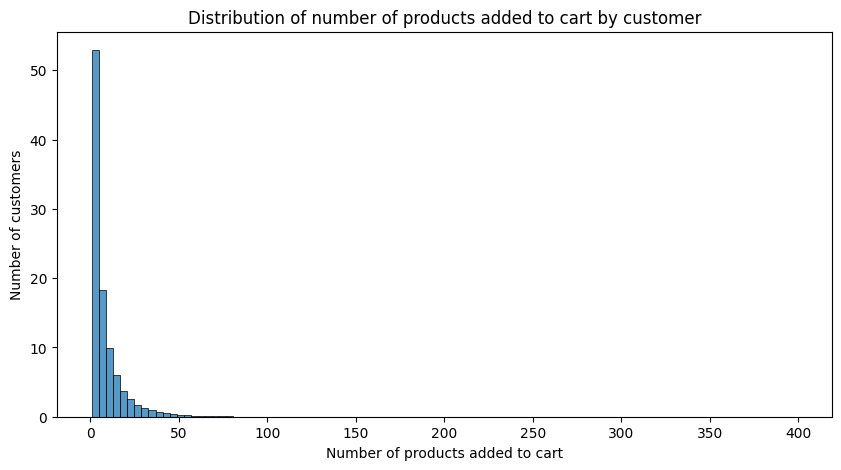

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_carts['product_code_carts'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products added to cart by customer')
plt.xlabel('Number of products added to cart')
plt.ylabel('Number of customers')
plt.show()

#### Number of products ordered vs. number of products clicked

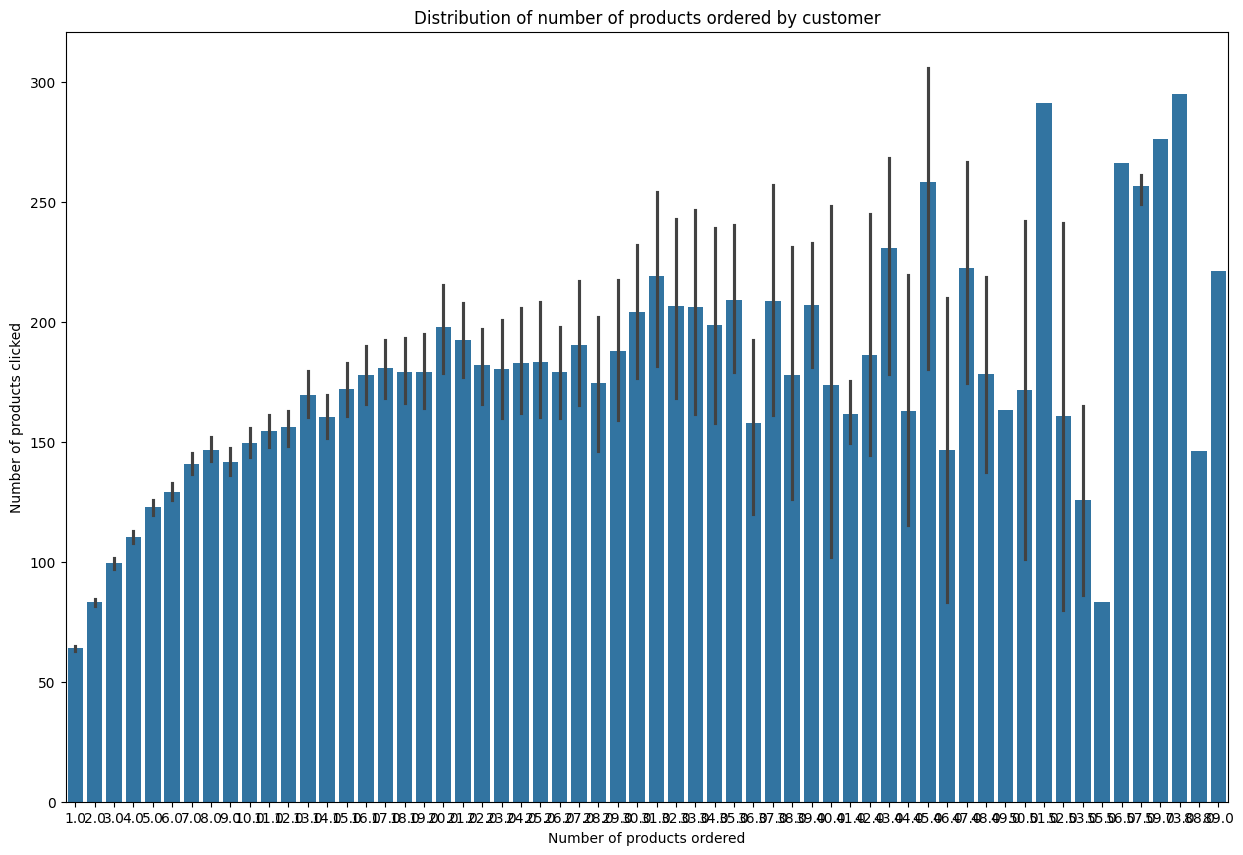

In [51]:
plt.figure(figsize=(15, 10))
sns.barplot(x=grouped_train_orders['product_code_orders'], y=grouped_train_clicks['product_code_clicks'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of products clicked')
plt.show()

#### Number of products ordered vs. number of products added to cart

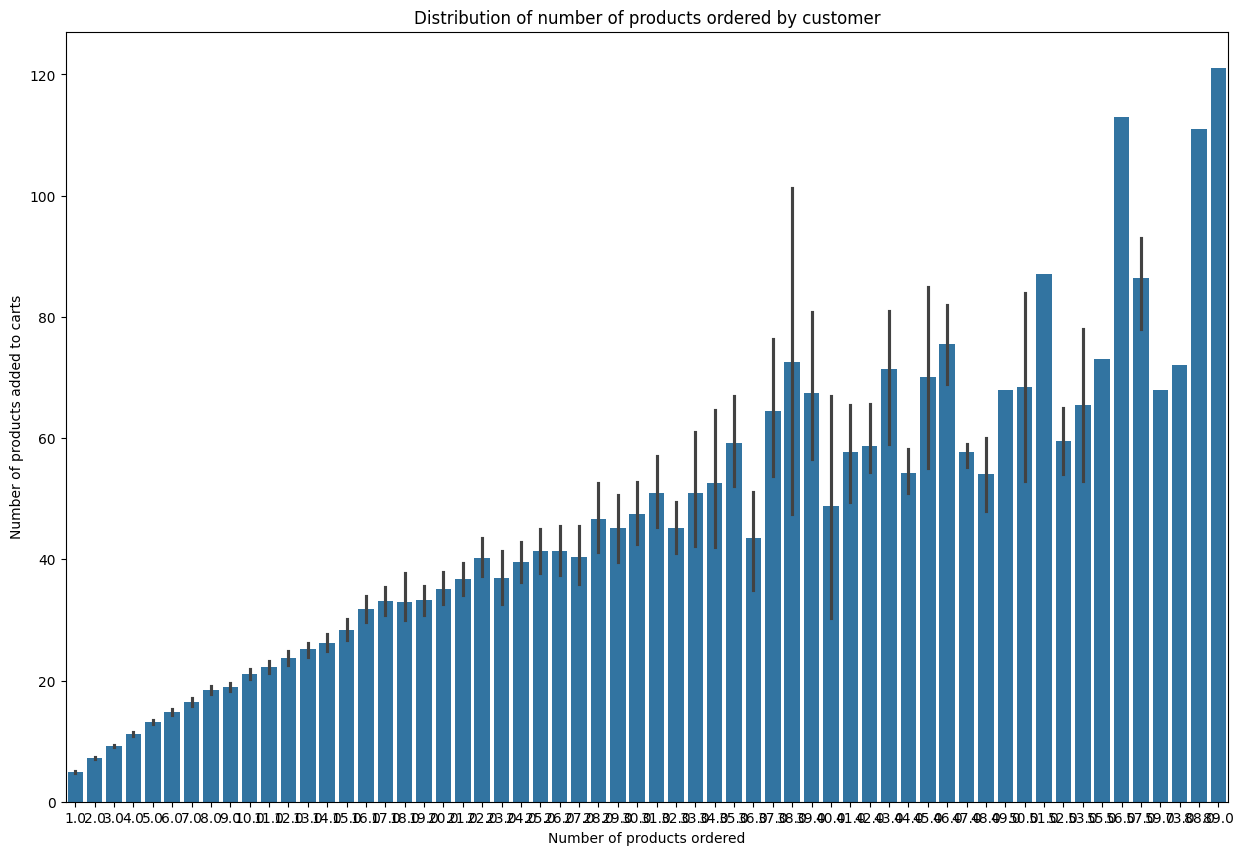

In [52]:
plt.figure(figsize=(15, 10))
sns.barplot(x=grouped_train_orders['product_code_orders'], y=grouped_train_carts['product_code_carts'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of products added to carts')
plt.show()